## Import Necessary Modules

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir
import warnings
warnings.filter("ignore")

%matplotlib inline

In [68]:
def load_data(dir_list, image_size):

    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            
            X.append(image)
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y


In [11]:
augmented_path = r"E:download/btf/Brain-Tumor-Detection-master/augmented data"

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + '/yes' 
augmented_no = augmented_path + '/no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


As we see, we have 2065 images. Each images has a shape of **(240, 240, 3)=(image_width, image_height, number_of_channels)**

### Plot sample images:

### Split the data:
Split <i>X</i> and <i>y</i> into training, validation (development) and validation sets.

In [12]:
def split_data(X, y, test_size=0.2):
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

Let's use the following way to split:<br>
1. 70% of the data for training.
2. 15% of the data for validation.
3. 15% of the data for testing.

In [13]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [14]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1445
number of development examples = 310
number of test examples = 310
X_train shape: (1445, 240, 240, 3)
Y_train shape: (1445, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


Some helper functions:

In [15]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [16]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

# Build the model

Let's build a convolutional neural network model:

In [17]:
def build_model(input_shape):
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

Define the image shape:

In [18]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [19]:
model = build_model(IMG_SHAPE)

In [20]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 244, 244, 3)      0         
 2D)                                                             
                                                                 
 conv0 (Conv2D)              (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation (Activation)     (None, 238, 238, 32)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 59, 59, 32)        0         
                                               

Compile the model:

In [21]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [25]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

## Train the model

In [26]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
46/46 [==============================] - ETA: 0s - loss: 0.4755 - accuracy: 0.7820

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.73.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.73.model\assets


46/46 [==============================] - 94s 2s/step - loss: 0.4755 - accuracy: 0.7820 - val_loss: 0.6071 - val_accuracy: 0.7290
Epoch 2/10
46/46 [==============================] - ETA: 0s - loss: 0.4064 - accuracy: 0.8325

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.63.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.63.model\assets


46/46 [==============================] - 90s 2s/step - loss: 0.4064 - accuracy: 0.8325 - val_loss: 0.6007 - val_accuracy: 0.6323
Epoch 3/10
46/46 [==============================] - ETA: 0s - loss: 0.3816 - accuracy: 0.8346

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.81.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.81.model\assets


46/46 [==============================] - 92s 2s/step - loss: 0.3816 - accuracy: 0.8346 - val_loss: 0.4961 - val_accuracy: 0.8097
Epoch 4/10
46/46 [==============================] - ETA: 0s - loss: 0.3045 - accuracy: 0.8789

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.78.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.78.model\assets


46/46 [==============================] - 94s 2s/step - loss: 0.3045 - accuracy: 0.8789 - val_loss: 0.4829 - val_accuracy: 0.7806
Epoch 5/10
46/46 [==============================] - ETA: 0s - loss: 0.3261 - accuracy: 0.8630

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.83.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.83.model\assets


46/46 [==============================] - 88s 2s/step - loss: 0.3261 - accuracy: 0.8630 - val_loss: 0.4269 - val_accuracy: 0.8290
Epoch 6/10
46/46 [==============================] - ETA: 0s - loss: 0.2538 - accuracy: 0.8976

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-06-0.82.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-06-0.82.model\assets


46/46 [==============================] - 86s 2s/step - loss: 0.2538 - accuracy: 0.8976 - val_loss: 0.3959 - val_accuracy: 0.8194
Epoch 7/10
46/46 [==============================] - ETA: 0s - loss: 0.2448 - accuracy: 0.9045

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-07-0.59.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-07-0.59.model\assets


46/46 [==============================] - 85s 2s/step - loss: 0.2448 - accuracy: 0.9045 - val_loss: 0.8370 - val_accuracy: 0.5871
Epoch 8/10
46/46 [==============================] - ETA: 0s - loss: 0.2482 - accuracy: 0.8955

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-08-0.73.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-08-0.73.model\assets


46/46 [==============================] - 87s 2s/step - loss: 0.2482 - accuracy: 0.8955 - val_loss: 0.5596 - val_accuracy: 0.7258
Epoch 9/10
46/46 [==============================] - ETA: 0s - loss: 0.2612 - accuracy: 0.8872

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-09-0.83.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-09-0.83.model\assets


46/46 [==============================] - 87s 2s/step - loss: 0.2612 - accuracy: 0.8872 - val_loss: 0.4074 - val_accuracy: 0.8258
Epoch 10/10
46/46 [==============================] - ETA: 0s - loss: 0.2060 - accuracy: 0.9273

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-10-0.83.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-10-0.83.model\assets


46/46 [==============================] - 86s 2s/step - loss: 0.2060 - accuracy: 0.9273 - val_loss: 0.3583 - val_accuracy: 0.8323
Elapsed time: 0:15:0.2


Let's train for a few more epochs:

In [27]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 [==============================] - ETA: 0s - loss: 0.2256 - accuracy: 0.9010

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.69.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.69.model\assets


46/46 [==============================] - 91s 2s/step - loss: 0.2256 - accuracy: 0.9010 - val_loss: 0.9414 - val_accuracy: 0.6871
Epoch 2/3
46/46 [==============================] - ETA: 0s - loss: 0.2207 - accuracy: 0.9080

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.75.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.75.model\assets


46/46 [==============================] - 86s 2s/step - loss: 0.2207 - accuracy: 0.9080 - val_loss: 0.5580 - val_accuracy: 0.7548
Epoch 3/3
46/46 [==============================] - ETA: 0s - loss: 0.1671 - accuracy: 0.9398

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.72.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.72.model\assets


46/46 [==============================] - 89s 2s/step - loss: 0.1671 - accuracy: 0.9398 - val_loss: 0.6606 - val_accuracy: 0.7226
Elapsed time: 0:4:38.8


In [28]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 [==============================] - ETA: 0s - loss: 0.1592 - accuracy: 0.9370

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.88.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.88.model\assets


46/46 [==============================] - 88s 2s/step - loss: 0.1592 - accuracy: 0.9370 - val_loss: 0.2748 - val_accuracy: 0.8806
Epoch 2/3
46/46 [==============================] - ETA: 0s - loss: 0.1402 - accuracy: 0.9474

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.87.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.87.model\assets


46/46 [==============================] - 86s 2s/step - loss: 0.1402 - accuracy: 0.9474 - val_loss: 0.3223 - val_accuracy: 0.8677
Epoch 3/3
46/46 [==============================] - ETA: 0s - loss: 0.1235 - accuracy: 0.9599

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.89.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.89.model\assets


46/46 [==============================] - 82s 2s/step - loss: 0.1235 - accuracy: 0.9599 - val_loss: 0.2721 - val_accuracy: 0.8935
Elapsed time: 0:4:28.7


In [29]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 [==============================] - ETA: 0s - loss: 0.1261 - accuracy: 0.9612

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.90.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.90.model\assets


46/46 [==============================] - 91s 2s/step - loss: 0.1261 - accuracy: 0.9612 - val_loss: 0.2441 - val_accuracy: 0.9032
Epoch 2/3
46/46 [==============================] - ETA: 0s - loss: 0.1001 - accuracy: 0.9709

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.90.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.90.model\assets


46/46 [==============================] - 91s 2s/step - loss: 0.1001 - accuracy: 0.9709 - val_loss: 0.2699 - val_accuracy: 0.9000
Epoch 3/3
46/46 [==============================] - ETA: 0s - loss: 0.1120 - accuracy: 0.9633

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.88.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.88.model\assets


46/46 [==============================] - 89s 2s/step - loss: 0.1120 - accuracy: 0.9633 - val_loss: 0.2824 - val_accuracy: 0.8774
Elapsed time: 0:4:44.1


In [30]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/5
46/46 [==============================] - ETA: 0s - loss: 0.0906 - accuracy: 0.9806

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.89.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.89.model\assets


46/46 [==============================] - 94s 2s/step - loss: 0.0906 - accuracy: 0.9806 - val_loss: 0.2534 - val_accuracy: 0.8903
Epoch 2/5
46/46 [==============================] - ETA: 0s - loss: 0.0818 - accuracy: 0.9806

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.88.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.88.model\assets


46/46 [==============================] - 88s 2s/step - loss: 0.0818 - accuracy: 0.9806 - val_loss: 0.2945 - val_accuracy: 0.8774
Epoch 3/5
46/46 [==============================] - ETA: 0s - loss: 0.1061 - accuracy: 0.9619

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.90.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.90.model\assets


46/46 [==============================] - 81s 2s/step - loss: 0.1061 - accuracy: 0.9619 - val_loss: 0.2623 - val_accuracy: 0.9000
Epoch 4/5
46/46 [==============================] - ETA: 0s - loss: 0.0869 - accuracy: 0.9758

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.90.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.90.model\assets


46/46 [==============================] - 79s 2s/step - loss: 0.0869 - accuracy: 0.9758 - val_loss: 0.2777 - val_accuracy: 0.9000
Epoch 5/5
46/46 [==============================] - ETA: 0s - loss: 0.0598 - accuracy: 0.9917

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.87.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.87.model\assets


46/46 [==============================] - 82s 2s/step - loss: 0.0598 - accuracy: 0.9917 - val_loss: 0.3636 - val_accuracy: 0.8742
Elapsed time: 0:7:16.1


In [31]:
history = model.history.history

In [32]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


## Plot Loss & Accuracy

In [65]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.ylim(0,1)
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.ylim(0,1)
    plt.title('Accuracy')
    plt.legend()
    plt.show()

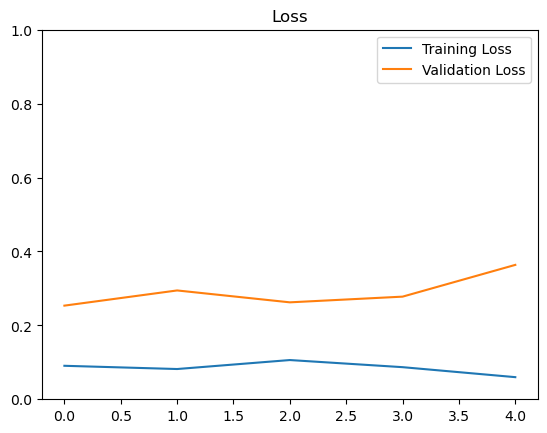

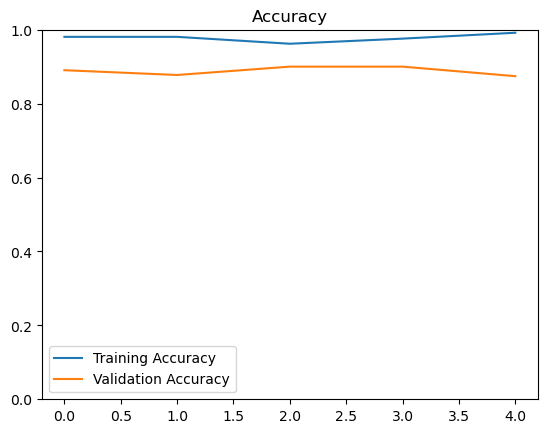

In [66]:
plot_metrics(history) 

### Load the best model

In [50]:
best_model = load_model(filepath='E:/download/btf/Brain-Tumor-Detection-master/models/cnn-parameters-improvement-21-0.83.model')

In [51]:
best_model.metrics_names

['loss', 'accuracy']

Evaluate the best model on the testing data:

In [52]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

10/10 [==============================] - 4s 372ms/step - loss: 0.1992 - accuracy: 0.9290


### Accuracy of the best model on the testing data:

In [53]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.19923265278339386
Test Accuracy = 0.9290322661399841
